# Digital Gauge Reader:- Analog-to-Digital Conversion Using Computer Vision

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib as plt

In [2]:

detection_model = YOLO('runs100/detect/train/weights/best.pt')
segmentation_model = YOLO('runs/segment/train2/weights/best.pt')


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
needle_initial = Image.open('rotated358.png').convert('RGBA')
needle_target = Image.open('segmented_needle_frame_1221.png').convert('RGBA')


In the above code needle initial is the needle image at minimum reading (needle at 0 reading) and needle target is the needle image at maximum reading (needle at 100 reading).


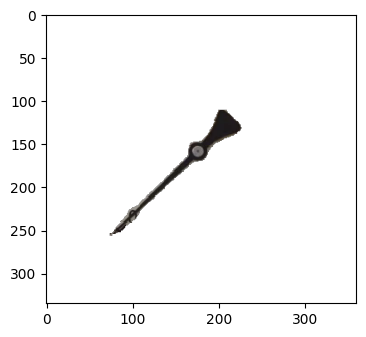

In [10]:
plt.figure(figsize=(4, 4)) 
plt.imshow(needle_initial)

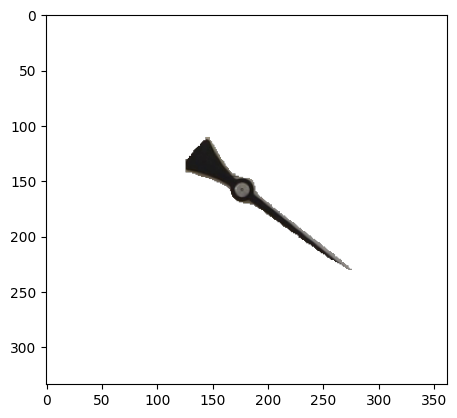

In [6]:
plt.imshow(needle_target)

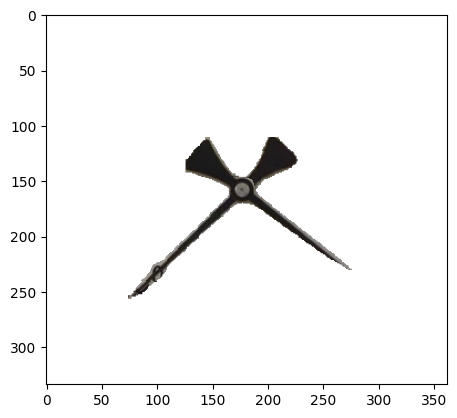

In [4]:
plt.imshow(needle_initial)
plt.imshow(needle_target)

In [7]:
print(f"needle_initial size: {needle_initial.size}")  
print(f"needle_target size: {needle_target.size}")  

needle_initial size: (360, 335)
needle_target size: (362, 334)


Precomputation Part

In [ ]:
from skimage.metrics import structural_similarity as ssim

needle_initial = Image.open('rotated358.png').convert('RGBA')
needle_target = Image.open('segmented_needle_frame_1221.png').convert('RGBA')

needle_initial_center = (175, 160)
needle_target_center = (177, 158)  

fixed_size = needle_target.size
needle_initial = needle_initial.resize(fixed_size, Image.Resampling.LANCZOS)

def calculate_rotation_angle(needle_initial, needle_target, start_angle=0, end_angle=360, win_size=5):
    min_diff = float('inf')
    best_angle = start_angle

    for angle in range(start_angle, end_angle + 1):
       
        rotated_needle = needle_initial.rotate(-angle, resample=Image.Resampling.BICUBIC, center=needle_initial_center, expand=False)

        resized_needle = rotated_needle.resize(fixed_size, Image.Resampling.LANCZOS)
        resized_target = needle_target.resize(fixed_size, Image.Resampling.LANCZOS)
     
        rotated_needle_np = np.asarray(resized_needle)
        resized_target_np = np.asarray(resized_target)

        ssim_diff, _ = ssim(rotated_needle_np, resized_target_np, win_size=win_size, full=True, channel_axis=2)
        ssim_diff = 1 - ssim_diff 

        if ssim_diff < min_diff:
            min_diff = ssim_diff
            best_angle = angle
            print(f'Current min_diff: {min_diff}, Best angle: {best_angle}')
    
    print(f'Final min_diff: {min_diff}, Best angle: {best_angle}')
    return best_angle


angle_0_to_100 = calculate_rotation_angle(needle_initial, needle_target)
print(f"Best angle to rotate needle from 0 to 100: {angle_0_to_100} degrees")


Current min_diff: 0.05771439336001305, Best angle: 0
Current min_diff: 0.05708761566396181, Best angle: 1
Current min_diff: 0.05706631718483046, Best angle: 2
Current min_diff: 0.057018829224225964, Best angle: 34
Current min_diff: 0.05683435111120827, Best angle: 37
Current min_diff: 0.05681569630938055, Best angle: 38
Current min_diff: 0.05650859440057099, Best angle: 42
Current min_diff: 0.05644559523296788, Best angle: 45
Current min_diff: 0.0562787016437607, Best angle: 46
Current min_diff: 0.0559201174862235, Best angle: 47
Current min_diff: 0.055884562922077885, Best angle: 48
Current min_diff: 0.05552901551379863, Best angle: 49
Current min_diff: 0.05511673790495819, Best angle: 50
Current min_diff: 0.05494499525967367, Best angle: 51
Current min_diff: 0.05446448750565147, Best angle: 52
Current min_diff: 0.05402019207589337, Best angle: 53
Current min_diff: 0.053475708193758575, Best angle: 54
Current min_diff: 0.05301057827110722, Best angle: 55
Current min_diff: 0.0525747465

Insight:- Here we got angle for full rotation as 261 degrees. Thus degrees per unit is 2.61

Production Enviornment

In [8]:
import os
import cv2
import numpy as np
from PIL import Image

video_path = 'newneedle3.mp4'
output_video_path = 'crop_gauge_video.mp4'
needle_initial_img_path = 'rotated358.png'


needle_initial = Image.open(needle_initial_img_path).convert('RGBA')
needle_initial_size = needle_initial.size  


cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Error opening video file")

fps = cap.get(cv2.CAP_PROP_FPS)


fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_video_path, fourcc, fps, needle_initial_size)  

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  
  
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    detection_results = detection_model.predict(frame_rgb, conf=0.30)

    if detection_results and detection_results[0].boxes:
        box = detection_results[0].boxes[0]  
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

        cropped_gauge = frame[y1:y2, x1:x2]
        
        cropped_gauge_pil = Image.fromarray(cv2.cvtColor(cropped_gauge, cv2.COLOR_BGR2RGB))

        resized_gauge = cropped_gauge_pil.resize(needle_initial_size, Image.Resampling.LANCZOS)

        resized_gauge_cv2 = cv2.cvtColor(np.array(resized_gauge), cv2.COLOR_RGB2BGR)

        out.write(resized_gauge_cv2)

        print(f"Processed frame {frame_number} and added to the output video")

    frame_number += 1


cap.release()
out.release()

print(f"Output video saved to {output_video_path}")


0: 384x640 1 Gauge, 74.6ms
Speed: 3.1ms preprocess, 74.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 0 and added to the output video

0: 384x640 1 Gauge, 55.1ms
Speed: 2.5ms preprocess, 55.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 1 and added to the output video

0: 384x640 1 Gauge, 68.8ms
Speed: 2.6ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 2 and added to the output video

0: 384x640 1 Gauge, 56.6ms
Speed: 1.8ms preprocess, 56.6ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 3 and added to the output video

0: 384x640 1 Gauge, 53.8ms
Speed: 1.5ms preprocess, 53.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 4 and added to the output video

0: 384x640 1 Gauge, 73.4ms
Speed: 1.5ms preprocess, 73.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Processed 

Needle tip coordinates of Needle initial

In [72]:
import cv2

image = cv2.imread('rotated358.png')

def get_coordinates(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN: 
        print(f'Needle_tip Coordinates of needle initial: ({x}, {y})')


cv2.namedWindow('Image')
cv2.setMouseCallback('Image', get_coordinates)

while True:
    cv2.imshow('Image', image)
    if cv2.waitKey(1) & 0xFF == 27:  
        break

cv2.destroyAllWindows()

Needle_tip Coordinates of needle initial: (86, 245)


Reading calculation

In [20]:
import math

segmentation_model = YOLO('runs/segment/train2/weights/best.pt')

def calculate_angle_from_three_points(initial_tip, gauge_center, current_tip):
    
    v1 = np.array(initial_tip) - np.array(gauge_center)
   
    v2 = np.array(current_tip) - np.array(gauge_center)
    
    angle_rad = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    
    angle_deg = np.degrees(angle_rad)
    
    angle_deg = angle_deg % 354
    
    return angle_deg

def detect_needle_tip(frame):
    results = segmentation_model(frame)
    boxes = results[0].boxes.xyxy
    confidences = results[0].boxes.conf
    classes = results[0].boxes.cls
    
    needle_tip = None
    needle_class_id = 2  
    
    for i in range(len(boxes)):
        if classes[i] == needle_class_id and confidences[i] > 0.40:
            x1, y1, x2, y2 = boxes[i]
            needle_tip = ((x1 + x2) / 2, (y1 + y2) / 2)
           
            break 
    return needle_tip

cap = cv2.VideoCapture('crop_gauge_video.mp4')

ret, first_frame = cap.read()
if not ret:
    print("Error reading video")
    exit()

gauge_center = (181, 158)  
initial_needle_tip = (86, 245)
angles = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    current_needle_tip = detect_needle_tip(frame)

    if current_needle_tip is not None:
        angle = calculate_angle_from_three_points(initial_needle_tip, gauge_center, current_needle_tip)
        angles.append(angle)
        reading = angle/2.61
        cv2.putText(frame, f"Gauge reading:- { reading:.0f}", (18, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow("Gauge Reading", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

with open('angles_calculated.txt', 'w') as f:
    for angle in angles:
        f.write(f"{reading:.0f}\n")

print("Angles calculated and saved to angles_calculated.txt")



0: 608x640 1 needle, 1 needle center, 1 needle tip, 298.3ms
Speed: 10.1ms preprocess, 298.3ms inference, 10.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 needle, 1 needle center, 1 needle tip, 310.7ms
Speed: 13.7ms preprocess, 310.7ms inference, 10.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 needle, 1 needle center, 1 needle tip, 244.1ms
Speed: 10.1ms preprocess, 244.1ms inference, 8.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 needle, 1 needle center, 1 needle tip, 243.8ms
Speed: 8.0ms preprocess, 243.8ms inference, 10.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 needle, 1 needle center, 1 needle tip, 296.0ms
Speed: 10.1ms preprocess, 296.0ms inference, 14.2ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 needle, 1 needle center, 1 needle tip, 258.3ms
Speed: 10.1ms preprocess, 258.3ms inference, 10.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 needle, 1 needle cente